In [1]:
import sys
sys.path.append("../..")

import numpy as np
from matplotlib import pyplot as plt
from scipy import stats as ss

from transfernode import node
from transfernode import line
from stochastic import stochastic
from genetics import ga
import tools

In [2]:
avtovokzal = node.Node()
# start times counting from 5AM: [75, 90, 30, 95, 0]
# start times counting from 6:30AM: [20, 0, 0, 5, 14]
line1 = line.Line(75, 15 + 20, stochastic.Stochastic(1, 3, 0.5), 0.35, "#1")
line2 = line.Line(90, 30, stochastic.Stochastic(1, 4, 1), 0.20, "#2")
line3 = line.Line(30, 20, stochastic.Stochastic(1, 5, 1), 0.25, "#3")
line4 = line.Line(95, 28, stochastic.Stochastic(1, 4, 0.5), 0.10, "#4")
line5 = line.Line(0, 26, stochastic.Stochastic(1, 4, 0.5), 0.10, "#5")

avtovokzal.origin_pass_number = 12  # [pas./h]
avtovokzal.lines = [line1, line2, line3, line4, line5]

In [3]:
nd, dur, N = avtovokzal, 180, 300

def fitness_function(shifts):
    for idx in range(len(nd.lines)):
        nd.lines[idx].shift = shifts[idx]
    res = []
    for _ in range(N):
        x = nd.simulate(duration=dur)
        res.append(x[0] / x[1])
    return np.array(res)

# res = fitness_function([20, 0, 0, 5, 14])
# res = fitness_function([75, 90, 30, 95, 0])

## Run GA

In [4]:
N = 100

winners = []
for pm in range(1, 11):
    ws = []
    for tm in range(1, 11):
        print(pm, tm)
        g = ga.GA()
        g.chromosome_size = len(avtovokzal.lines), 7
        g.population_size = 100
        g.generations = 10
        g.crossover_probability = 0.5
        g.mutation_probability = 0.05 * pm
        g.mutation_turns = tm
        g.fitness_function = lambda xs: fitness_function(xs).mean()
        winner = g.run()
        ws.append(winner[1])
        print()
    winners.append(ws)
    print()

1 1
winner #1 ([8, 22, 28, 28, 10], (13.785623102639583, <genetics.chromosome.Chromosome object at 0x169870790>))
winner #2 ([31, 27, 19, 27, 37], (13.267357315809273, <genetics.chromosome.Chromosome object at 0x169884b20>))
winner #3 ([8, 22, 28, 28, 14], (13.205549985867956, <genetics.chromosome.Chromosome object at 0x169870280>))
winner #4 ([31, 27, 19, 28, 23], (13.136391671569227, <genetics.chromosome.Chromosome object at 0x1698841f0>))
winner #5 ([31, 27, 19, 28, 23], (12.95636895384809, <genetics.chromosome.Chromosome object at 0x169851b40>))
winner #6 ([31, 27, 19, 28, 19], (12.928725275070457, <genetics.chromosome.Chromosome object at 0x169884f70>))
winner #7 ([31, 27, 19, 28, 19], (12.83306256861631, <genetics.chromosome.Chromosome object at 0x169870100>))
winner #8 ([31, 27, 18, 28, 18], (12.845271100314463, <genetics.chromosome.Chromosome object at 0x169853d30>))
winner #9 ([31, 27, 18, 28, 19], (12.855501669379471, <genetics.chromosome.Chromosome object at 0x169885930>))
w

In [7]:
np.array(winners).tofile('node_results/node_pm_pn_10x10x10.txt', sep=',', format='%s')

## Analyze results

In [8]:
xs = np.fromfile('node_results/node_pm_pn_10x10x10.txt', sep=',').reshape((10, 10, 10))
linear = lambda a, b, c, x1, x2: a + b * x1 + c * x2

In [9]:
tticks = np.array([x for x in range(1, 11, 1)])
pticks = np.array([0.05 * x for x in range(1, 11, 1)])
X = np.array([np.array([[x] * 10 for x in pticks]).flatten(), [x for x in tticks] * 10]).T
rm_min = tools.make_regression(X, xs.min(axis=2).flatten(), alpha=0.001, verbose=True)[0]
rm_max = tools.make_regression(X, xs.max(axis=2).flatten(), alpha=0.001, verbose=True)[0]
rm_mean = tools.make_regression(X, xs.mean(axis=2).flatten(), alpha=0.001, verbose=True)[0]

intercept=12.59775347041372
coefs=[0.0077121 0.0026422]
R2=0.004960444514226947
t_alfa(0.001,97)=3.393669851880678
coef1	False	-0.18732147386126508	0.2027456638843953
coef2	False	-0.00710948043093611	0.012393876456346906
intercept=13.967442359971429
coefs=[ 0.80523515 -0.02524437]
R2=0.052773872942063815
t_alfa(0.001,97)=3.393669851880678
coef1	False	-0.23304526577566131	1.8435155614703764
coef2	False	-0.07715838653328108	0.0266696548290208
intercept=13.07727699151387
coefs=[ 0.04198592 -0.0064983 ]
R2=0.016905232432905426
t_alfa(0.001,97)=3.393669851880678
coef1	False	-0.22657980072096645	0.31055165020216785
coef2	False	-0.019926586090084936	0.0069299864560717715


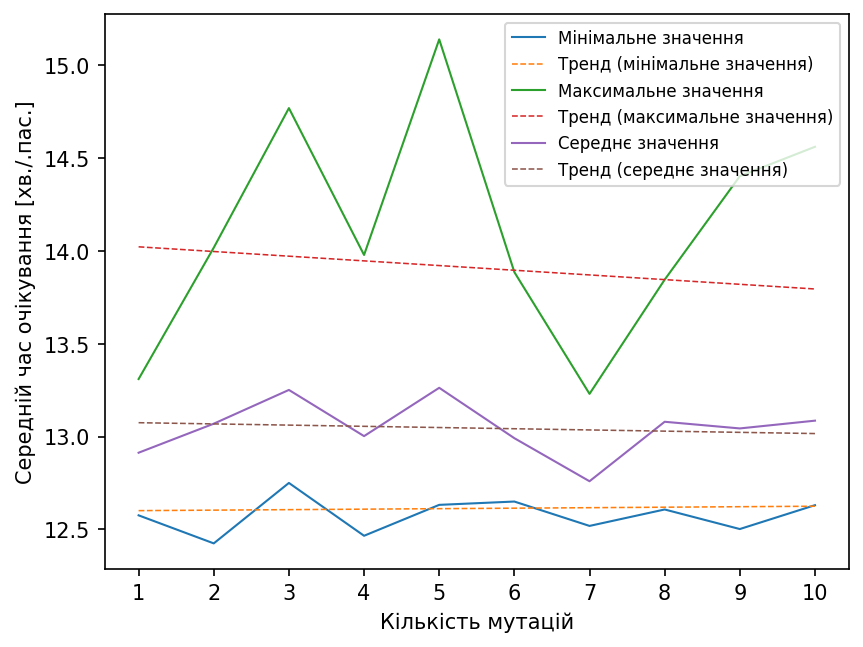

In [12]:
i = 1

plt.figure(dpi=150)

plt.plot(tticks, xs[i].min(axis=1), lw=1.0, label='Мінімальне значення', linestyle='-')
plt.plot(tticks, linear(rm_min.intercept_, rm_min.coef_[0], rm_min.coef_[1], pticks[i], tticks),
         lw=0.75, label='Тренд (мінімальне значення)', linestyle='--')

plt.plot(tticks, xs[i].max(axis=1), lw=1.0, label='Максимальне значення', linestyle='-')
plt.plot(tticks, linear(rm_max.intercept_, rm_max.coef_[0], rm_max.coef_[1], pticks[i], tticks),
         lw=0.75, label='Тренд (максимальне значення)', linestyle='--')

plt.plot(tticks, xs[i].mean(axis=1), lw=1.0, label='Середнє значення', linestyle='-')
plt.plot(tticks, linear(rm_mean.intercept_, rm_mean.coef_[0], rm_mean.coef_[1], pticks[i], tticks),
         lw=0.75, label='Тренд (середнє значення)', linestyle='--')

plt.ylabel('Середній час очікування [хв./.пас.]')
plt.xlabel('Кількість мутацій')
plt.xticks(tticks)
plt.legend(fontsize=8, loc='upper right')

plt.show()

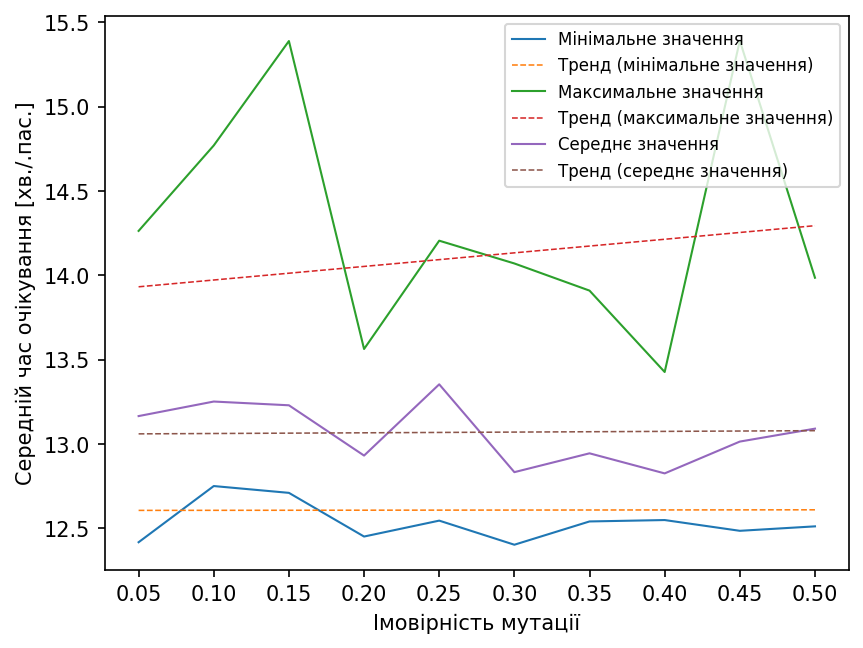

In [14]:
j = 2

plt.figure(dpi=150)

plt.plot(pticks, xs[:, j].min(axis=1), lw=1.0, label='Мінімальне значення', linestyle='-')
plt.plot(pticks, linear(rm_min.intercept_, rm_min.coef_[0], rm_min.coef_[1], pticks, tticks[j]),
         lw=0.75, label='Тренд (мінімальне значення)', linestyle='--')

plt.plot(pticks, xs[:, j].max(axis=1), lw=1.0, label='Максимальне значення', linestyle='-')
plt.plot(pticks, linear(rm_max.intercept_, rm_max.coef_[0], rm_max.coef_[1], pticks, tticks[j]),
         lw=0.75, label='Тренд (максимальне значення)', linestyle='--')

plt.plot(pticks, xs[:, j].mean(axis=1), lw=1.0, label='Середнє значення', linestyle='-')
plt.plot(pticks, linear(rm_mean.intercept_, rm_mean.coef_[0], rm_mean.coef_[1], pticks, tticks[j]),
         lw=0.75, label='Тренд (середнє значення)', linestyle='--')

plt.ylabel('Середній час очікування [хв./.пас.]')
plt.xlabel('Імовірність мутації')
plt.xticks(pticks)
plt.legend(fontsize=8, loc='upper right')

plt.show()